In [1]:
import pandas as pd
from numpy import random

from consts import default_random_seed
from policy import policy_treat_by_D_cate, policy_treat_by_ignoring_trunc, policy_treat_by_composite_outcome, \
    policy_treat_by_zr_bounds
from sample_generation import create_sample, data_adjustments, \
    adjust_data_with_beta_estimations, simulate_counterfactuals
from strata import Strata
from zhang_rubin_help_func import calc_non_parametric_zhang_rubin, calc_zhang_rubin_bounds_analytically, plot_zhang_rubin_bounds_on_survivors, \
    calc_zhang_rubin_bounds_using_cvar_est, plot_zhang_rubin_bounds_no_x
random.seed(default_random_seed)

In [2]:
# rwd = data_adjustments(dataset='lalonde') # RWD = Real World Data set
rwd = data_adjustments(dataset='STAR') # RWD = Real World Data set

# $Y(t)|X,S_t=1$


In [3]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
sample_for_y_dist_s = sample_for_y_dist.loc[sample_for_y_dist.D_obs==0] # survivers only


In [4]:
print("\nExample from each strata:")
display(sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1))


Example from each strata:


,x,t,D0,D1,p_t0d0_x,p_t1d0_x,stratum,S1,S0,Y0,...,mu0,mu1,sigma_0,sigma_1,a0,b0,c0,a1,b1,c1
7918,-0.772476,0,0,0,0.941170,0.991612,AS,1.0,1.0,10.023207,...,8.455048,6.910096,1,1,0.0,2.0,10.0,0.0,4.0,10.0
4441,0.661246,0,0,0,0.792285,0.965735,AS,1.0,1.0,11.454635,...,11.322491,12.644982,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7416,-0.390478,1,0,0,0.916098,0.987757,AS,1.0,1.0,10.409915,...,9.219044,8.438087,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3417,0.308684,1,1,1,0.844397,0.975668,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9948,0.022873,0,1,1,0.878375,0.981605,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
5502,-0.534283,0,1,1,0.926511,0.989379,D,NaN,NaN,NaN,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
1133,-0.559634,1,0,1,0.928218,0.989643,H,NaN,0.0,-0.318115,...,-1.119267,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3691,0.049471,0,0,1,0.875504,0.981119,H,NaN,0.0,-0.175954,...,0.098943,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9260,-0.092492,0,0,1,0.890171,0.983577,H,NaN,0.0,0.499586,...,-0.184985,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7049,-0.025835,0,1,0,0.883483,0.982464,P,0.0,NaN,NaN,...,NaN,-0.103340,1,1,0.0,2.0,10.0,0.0,4.0,10.0


## Using observational data:
0.   Naive ATE
1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 0. Naive ATE

##### Simulated Data

In [5]:
print(f"Naive ATE for Y: {round(sample_for_y_dist.Y1.mean() - sample_for_y_dist.Y0.mean(),2)}")
print(f"ATE for D: {round(sample_for_y_dist.D1.mean() - sample_for_y_dist.D0.mean(),2)}")

Naive ATE for Y: -1.05
ATE for D: -0.11


##### rwd

In [6]:
print(f"Naive ATE for Y: {round(rwd.loc[rwd.t==1].Y_obs.mean() - rwd.loc[rwd.t==0].Y_obs.mean(),2)}")
print(f"ATE for D: {round(rwd.loc[rwd.t==1].D_obs.mean() - rwd.loc[rwd.t==0].D_obs.mean(),2)}")

Naive ATE for Y: 0.07
ATE for D: -0.03


### 1. Zhang & Rubin

#### Non parametric

##### Simulated Data

In [7]:
zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
as_df = sample_for_y_dist.loc[sample_for_y_dist.stratum==Strata.AS.name]
print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

Bounds by Zhang and Rubin: [-1.963831565780759, 0.2792491148288061]
Actual AS treatment effect: -0.09352604936304877


##### RWD = Real World Data set

In [8]:
zhang_rubin_lb_rwd, zhang_rubin_ub_rwd = calc_non_parametric_zhang_rubin(rwd)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb_rwd}, {zhang_rubin_ub_rwd}]")

Bounds by Zhang and Rubin: [-0.2959331517655422, 0.4347370777402621]


##### using CVaR

In [9]:
zhang_rubin_bounds_cvar = calc_zhang_rubin_bounds_using_cvar_est(sample_for_y_dist[['x','D_obs','Y_obs','t', 'p_t0d0_x', 'p_t1d0_x']])

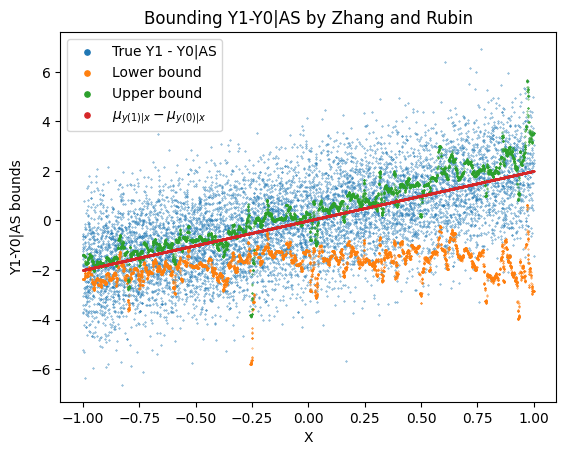

In [10]:
zhang_rubin_bounds_cvar_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar)

###### CVaR Without using simulated 'p_t0d0_x', 'p_t1d0_x', but estimating them (estimating beta)


In [11]:
sample_for_y_dist_hat = adjust_data_with_beta_estimations(sample_for_y_dist)

beta_d_hat: [-1.95, -2.12, 0.94]
(True beta_d: [-2.0, -2.0, 1.0])


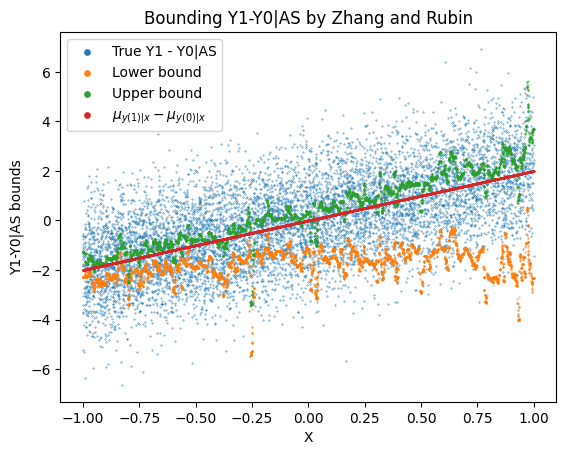

In [12]:
zhang_rubin_bounds_cvar_hat = calc_zhang_rubin_bounds_using_cvar_est(sample_for_y_dist_hat)
zhang_rubin_bounds_cvar_hat_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_cvar_hat)

###### RWD

In [13]:
rwd_hat = adjust_data_with_beta_estimations(rwd)

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]


In [14]:
zhang_rubin_bounds_cvar_hat_rwd = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat)

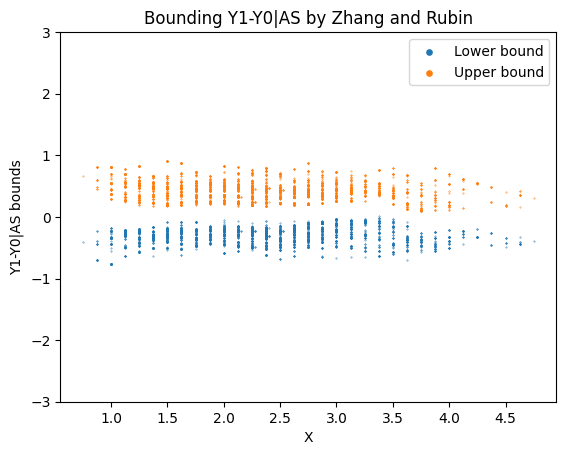

In [15]:
rwd_hat_s = rwd_hat.loc[rwd_hat.D_obs==0]
zhang_rubin_bounds_cvar_hat_rwd_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd, plot_graph_margin=True)

1 positive bounds (0.024%)
0 negative bounds (0.0%)


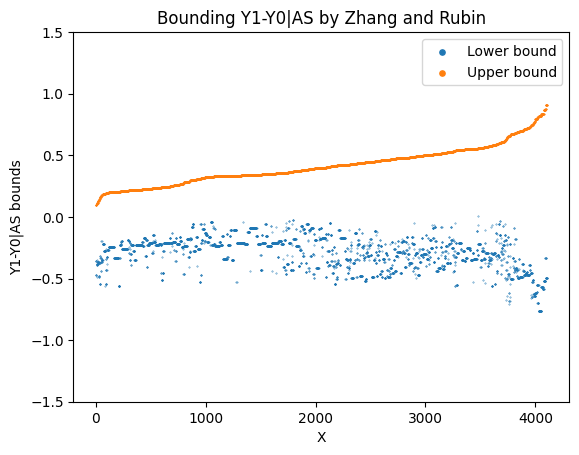

In [16]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_inc_x_and_cate, plot_graph_margin=True, margin=1.5)

In [17]:
rwd_semi_simulated = simulate_counterfactuals(rwd)
rwd_semi_simulated_s = rwd_semi_simulated.loc[rwd_semi_simulated.D_obs==0]

           counts  percentage
Strata.AS    2822   47.701149
Strata.P     1325   22.396890
Strata.H     1180   19.945909
Strata.D      589    9.956051


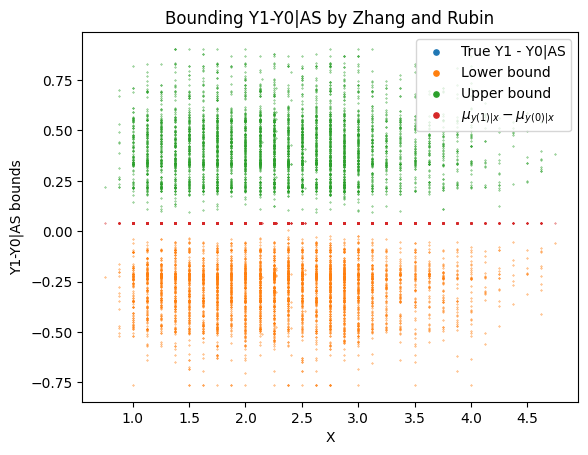

In [18]:
zhang_rubin_bounds_cvar_hat_rwd_semi_simulated_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_semi_simulated_s, zhang_rubin_bounds_cvar_hat_rwd)

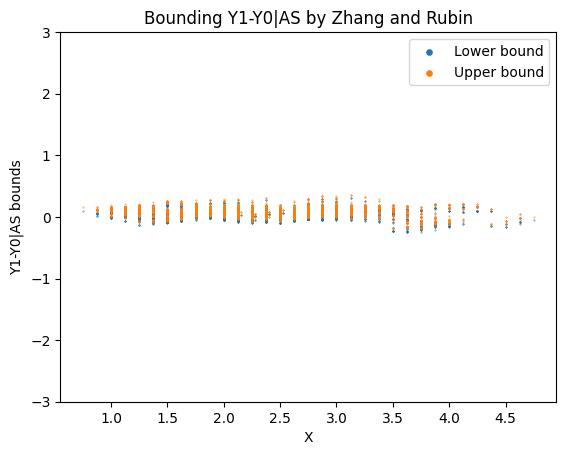

In [19]:
zhang_rubin_bounds_cvar_hat_rwd_mono = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat, monotonicity_assumption=True)
zhang_rubin_bounds_cvar_hat_rwd_mono_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd_mono, plot_graph_margin=True)

In [20]:
rwd_hat.loc[rwd_hat.D_obs==0].shape

(4106, 6)

2940 positive bounds (71.603%)
409 negative bounds (9.961%)


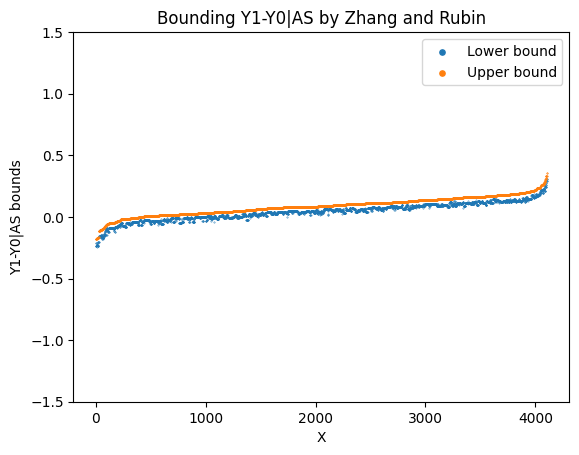

In [21]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_mono_inc_x_and_cate, plot_graph_margin=True, margin=1.5)

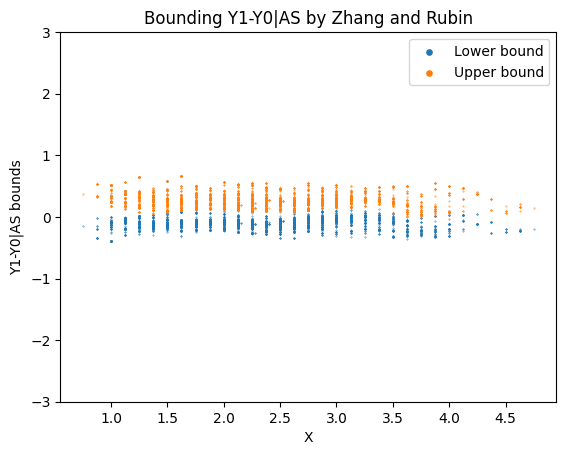

In [22]:
zhang_rubin_bounds_cvar_hat_rwd_ras = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat, ras_assumption=True)
zhang_rubin_bounds_cvar_hat_rwd_ras_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd_ras, plot_graph_margin=True)

325 positive bounds (7.915%)
0 negative bounds (0.0%)


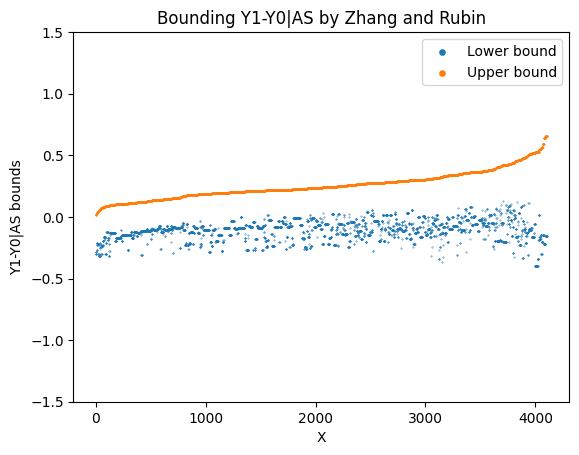

In [23]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_ras_inc_x_and_cate, plot_graph_margin=True, margin=1.5)

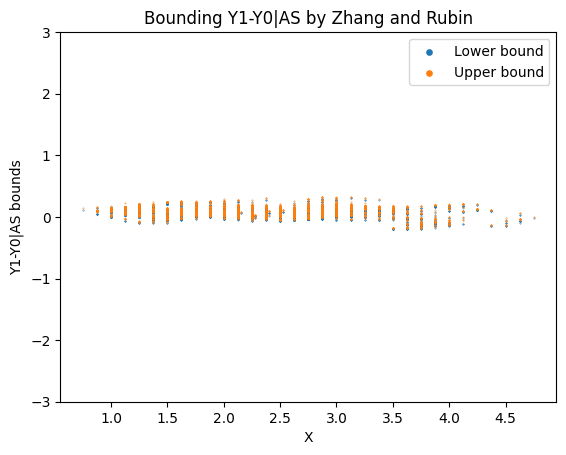

In [24]:
zhang_rubin_bounds_cvar_hat_rwd_mono_ras = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat, monotonicity_assumption=True, ras_assumption=True)
zhang_rubin_bounds_cvar_hat_rwd_mono_ras_inc_x_and_cate = plot_zhang_rubin_bounds_on_survivors(rwd_hat_s, zhang_rubin_bounds_cvar_hat_rwd_mono_ras, plot_graph_margin=True)

3309 positive bounds (80.589%)
439 negative bounds (10.692%)


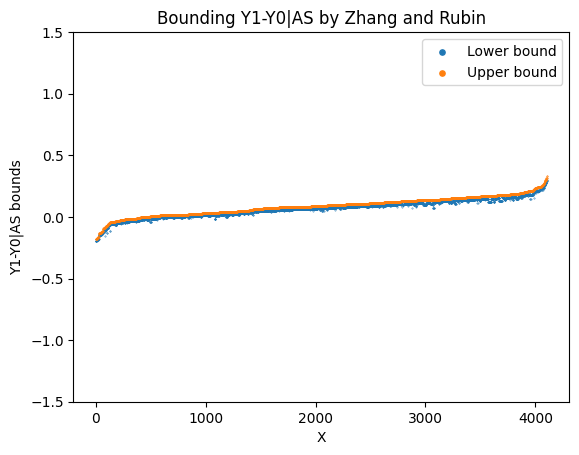

In [25]:
plot_zhang_rubin_bounds_no_x(zhang_rubin_bounds_cvar_hat_rwd_mono_ras_inc_x_and_cate, plot_graph_margin=True, margin=1.5)

### Policy Values on semi simulated dataset

In [26]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_D_cate(rwd_semi_simulated)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.4891053026225158, for survival ratio: 0.6763015551048006, for Y of AS: 0.5048100359408167


In [27]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_ignoring_trunc(rwd_semi_simulated)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5483747924902787, for survival ratio: 0.6957403651115619, for Y of AS: 0.5735072875093634


In [28]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_composite_outcome(rwd_semi_simulated)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5130933172771023, for survival ratio: 0.6959093982420554, for Y of AS: 0.5379256515987944


In [29]:
rwd_hat_semi_simulated = adjust_data_with_beta_estimations(rwd_semi_simulated[['x','t','D_obs','Y_obs']])
lb, ub = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_semi_simulated)
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_zr_bounds(rwd_semi_simulated, lb, ub)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]
Policy value for Y: 0.48458966313242985, for survival ratio: 0.7456051386071669, for Y of AS: 0.5047111897899329


In [30]:
# pd.DataFrame({"lb":lb, "ub":ub}).to_csv('path')

#### Policy values using assumptions

##### Monotonicity

In [31]:
rwd_semi_simulated_mono = simulate_counterfactuals(rwd, mono=True)
rwd_semi_simulated_mono_s = rwd_semi_simulated_mono.loc[rwd_semi_simulated_mono.D_obs==0]

           counts  percentage
Strata.AS    3674   62.102772
Strata.P     1325   22.396890
Strata.D      917   15.500338


In [32]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_ignoring_trunc(rwd_semi_simulated_mono)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5738680093501926, for survival ratio: 0.7670723461798512, for Y of AS: 0.5937658178640008


In [33]:
rwd_hat_semi_simulated_mono = adjust_data_with_beta_estimations(rwd_semi_simulated_mono[['x', 't', 'D_obs', 'Y_obs']])
lb, ub = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_semi_simulated_mono, monotonicity_assumption=True)
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_zr_bounds(rwd_semi_simulated_mono, lb, ub)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]
Policy value for Y: 0.5258649638023223, for survival ratio: 0.7373225152129818, for Y of AS: 0.538054728021


##### Ranked Average Score

In [34]:
rwd_semi_simulated_ras = simulate_counterfactuals(rwd, ras=True)
rwd_semi_simulated_ras_s = rwd_semi_simulated_ras.loc[rwd_semi_simulated_ras.D_obs==0]

           counts  percentage
Strata.AS    2822   47.701149
Strata.P     1325   22.396890
Strata.H     1180   19.945909
Strata.D      589    9.956051


In [35]:
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_ignoring_trunc(rwd_semi_simulated_ras)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

Policy value for Y: 0.5483747924902787, for survival ratio: 0.6957403651115619, for Y of AS: 0.5735072875093634


In [36]:
rwd_hat_semi_simulated_ras = adjust_data_with_beta_estimations(rwd_semi_simulated_ras[['x', 't', 'D_obs', 'Y_obs']])
lb, ub = calc_zhang_rubin_bounds_using_cvar_est(rwd_hat_semi_simulated_ras, ras_assumption=True)
policy_value_y, policy_value_d, policy_value_y_as = policy_treat_by_zr_bounds(rwd_semi_simulated_ras, lb, ub)
print(f"Policy value for Y: {policy_value_y}, for survival ratio: {policy_value_d}, for Y of AS: {policy_value_y_as}")

beta_d_hat: [0.34, -0.14, 0.37, -0.14, -0.16, -0.14, -0.34, -0.0, -0.02, 0.0]
Policy value for Y: 0.4849075825789777, for survival ratio: 0.7456051386071669, for Y of AS: 0.5052081219935908


#### Parametric

Lower bound:
$min_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} - \bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=0,D=0}},1\right]} \right]$ <br>
Upper bound:
$max_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} - \bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=0,D=0}}\right]} \right]$

<br><br>


$\Rightarrow\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{F_{Y_{(1)}}^{-1}(0)}^{F_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{F_{Y_{(1)}}^{-1}(0)}^{F_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$

<br>

$\Rightarrow\bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
\int_{F_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{F_{Y_{(1)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{P}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot \frac{1}{\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}} \cdot
  \int_{F_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)}^{F_{Y_{(1)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=0,D=0}},1\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}} \cdot
\int_{F_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=0,D=0}}\right)}^{F_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}} \cdot
  \int_{F_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=0,D=0}}\right)}^{F_{Y_{(0)}}^{-1}(1)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=0,D=0}}\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}}\cdot
\int_{F_{Y_{(0)}}^{-1}\left(0\right)}^{F_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=0,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{H}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot \frac{1}{1-\frac{\pi_h}{P_{T=0,D=0}}}\cdot
  \int_{F_{Y_{(0)}}^{-1}\left(0\right)}^{F_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=0,D=0}}\right)}
y\cdot\frac{1}{\sigma_{Y_{(0)}}\sqrt{2\pi}}
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}\right)^{\!2}\,\right)\,\cdot dy$

Note that the weights are identifiable from observational data:
$\frac{\pi_{P}}{\pi_{P}+\pi_{AS}}=\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)$ <br>
$\frac{\pi_{H}}{\pi_{H}+\pi_{AS}}=\left(\frac{\pi_h}{P_{T=0,D=0}}\right)$

<br>
$F_{Y_{(1)}}^{-1}(\alpha)=P(Y_{(1)}<F^{-1}(\alpha))$ where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y_{(1)}$. Although quantile function for mixed Gaussians does not admit a closed-form expression, it can be calculated. First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

In [37]:
# pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

In [38]:
zhang_rubin_bounds_analytic = calc_zhang_rubin_bounds_analytically(sample_for_y_dist_s)

row 0 out of 9238
row 1000 out of 9238
row 2000 out of 9238
row 3000 out of 9238
row 4000 out of 9238
row 5000 out of 9238
row 6000 out of 9238
row 7000 out of 9238
row 8000 out of 9238
row 9000 out of 9238


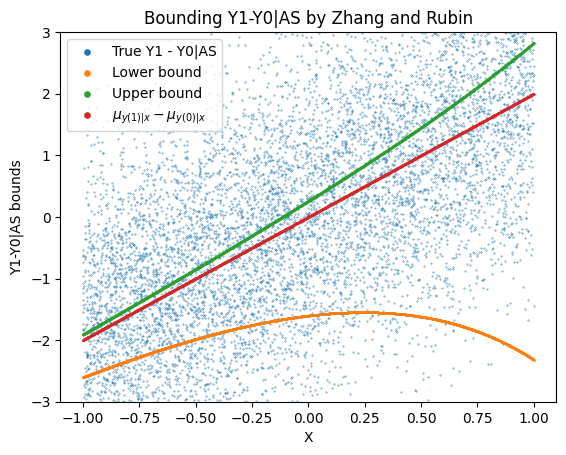

In [39]:
zr_bounds_analytic = plot_zhang_rubin_bounds_on_survivors(sample_for_y_dist_s, zhang_rubin_bounds_analytic, plot_graph_margin=True)

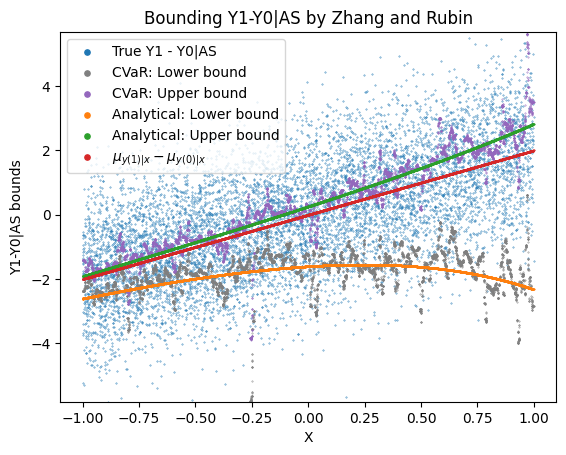

In [40]:
import matplotlib.pyplot as plt

df_plot_as = sample_for_y_dist_s.loc[sample_for_y_dist_s.stratum == Strata.AS.name]
plt.scatter(df_plot_as.x, (df_plot_as.Y1 - df_plot_as.Y0), label="True Y1 - Y0|AS", s=0.1)

plt.scatter(list(zhang_rubin_bounds_cvar_inc_x_and_cate['x']), zhang_rubin_bounds_cvar_inc_x_and_cate['lb'], label="CVaR: Lower bound", s=0.1, color='#7f7f7f')
plt.scatter(list(zhang_rubin_bounds_cvar_inc_x_and_cate['x']), zhang_rubin_bounds_cvar_inc_x_and_cate['up'], label="CVaR: Upper bound", s=0.1, color='#9467bd')

plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['lb'], label="Analytical: Lower bound", s=0.1)
plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['up'], label="Analytical: Upper bound", s=0.1)
plt.scatter(list(zr_bounds_analytic['x']), zr_bounds_analytic['true value'], label=r'$\mu_{y(1)|x}-\mu_{y(0)|x}$', s=0.1)

plt.legend(markerscale=12)
# plt.legend()
plt.title("Bounding Y1-Y0|AS by Zhang and Rubin")
plt.xlabel('X')
plt.ylabel('Y1-Y0|AS bounds')
plt.ylim((min(-3, min(min(zhang_rubin_bounds_cvar_inc_x_and_cate['lb']), min(zr_bounds_analytic['lb']))), max(3, max(max(zhang_rubin_bounds_cvar_inc_x_and_cate['up']), max(zr_bounds_analytic['up'])))))
plt.show()